In [1]:
import os
import sys
import gzip
import random
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import torch
import tqdm
import editdistance

In [2]:
SUBMISSION_TEMPLATE = '../input/car-plates-ocr-made/submission.csv'

EARLY_PRED_WEIGHT = 1.0
LAST_WEIGHT = 0.9
NEIGHBOURS_WEIGHT = 0.0
SINGLETON_THRESHOLD = 400
THRESHOLD = 20

In [3]:
with np.load('../input/made2-hw2-recognition-train-data/test_crops.npz') as data:
    crops = data['crops']
meta = pd.read_csv('../input/made2-hw2-recognition-train-data/test_meta.csv')

In [4]:
def load_predictions():
    # predictions from learning stage 1
    best, last = torch.load('../input/made2-hw2-recognition-pred/predictions.pth')
    # predictions from learning stage 2
    best_c, last_c = torch.load('../input/made2-hw2-recognition-pred-c/predictions.pth')
    predictions={}
    for pred, w in [(best,EARLY_PRED_WEIGHT),(last,EARLY_PRED_WEIGHT*LAST_WEIGHT),(best_c,1.0),(last_c,LAST_WEIGHT)]:
        for filename, crops in pred.items():
            if filename not in predictions:
                predictions[filename]=dict()
            for idx, versions in crops.items():
                if idx not in predictions[filename]:
                    predictions[filename][idx]=dict()
                p = predictions[filename][idx]
                for text, count in versions.items():
                    p[text] = p[text]+w*count if text in p else w*count
    return predictions


def filter_singletons(predictions):
    singletons={}
    for filename, crops in predictions.items():
        for versions in crops.values():
            for text, score in versions.items():
                if score<2:
                    singletons[text] = singletons[text]+1 if text in singletons else 1
    singletons = {k:v for k,v in singletons.items() if v>=SINGLETON_THRESHOLD}
    for filename, crops in predictions.items():
        for idx,versions in crops.items():
            for text in list(versions.keys()):
                if versions[text]<THRESHOLD:
                    for singleton in singletons:
                        if editdistance.eval(text,singleton)<2:
                            del versions[text]
                            break


def estimate(pred):
    if len(pred)==0:
        return ("", 0)
    versions = sorted(pred.items(), key=lambda kv: kv[1],reverse=True)
    scores=dict(pred)
    for i,(txt1,_) in enumerate(versions):
        for j,(txt2,_) in enumerate(versions):
            if i!=j:
                scores[txt1] = scores[txt1] + NEIGHBOURS_WEIGHT/editdistance.eval(txt1, txt2)/len(versions)
    return sorted(scores.items(), key=lambda kv: kv[1],reverse=True)[0]


def process_predictions(predictions, threshold=THRESHOLD):
    hard_samples = []
    plates_strings = {}
    for filename, crops in predictions.items():
        file_pred = []
        cur_best = ("",0)
        for order in sorted(crops.keys()):
            text, score = estimate(crops[order])
            if score>threshold:
                if text not in file_pred:
                    file_pred.append(text)
            elif score>cur_best[1]:
                cur_best=(text, score)
        if len(file_pred)==0:
            file_pred.append(cur_best[0])
            hard_samples.append((filename,cur_best[0],cur_best[1]))
            print(f"Hard: {filename} : {cur_best}")
        plates_strings[filename]=file_pred
    return plates_strings, hard_samples


def show(idx):
    df=meta[meta.img_idx==idx]
    filename = df.iloc[0]['filename']
    raw = raw_predictions[filename]
    raw = {k:raw[k] for k in sorted(raw)}
    print(raw)
    plt.figure(figsize=(16,12))
    image = cv2.imread('../input/carplates/data/data/'+filename)[:,:,::-1]
    for idx,c in df.iterrows():
        image = cv2.UMat(image)
        l, r, t, b, x, y = c['l'], c['r'], c['t'], c['b'], c['x'], c['y']
        pts = np.array([[l, b], [l, t], [r, t], [r, b]], dtype=np.int32)
        color = [(255, 0, 0),(0, 255, 0),(0, 0, 255),(0, 255, 255),(255, 0, 255),(255, 255, 0),(255, 255, 255)][c['crop_idx']%7]
        image = cv2.polylines(image, [pts.reshape(-1, 1, 2)], True, color, lineType=cv2.LINE_AA)
        image = cv2.putText(image, str(c['crop_idx']),  (x, y), cv2.FONT_HERSHEY_SIMPLEX, 1, color, 1, cv2.LINE_AA) 
    plt.imshow(cv2.UMat.get(image))
    plt.title(predictions[filename])


def show_crops(idx):
    df = meta[meta.img_idx==idx]
    cols = min(3,df.shape[0])
    rows = (df.shape[0]+cols-1)//cols
    plt.figure(figsize=(8*cols,3*rows))
    for i in range(df.shape[0]):
        plt.subplot(rows,cols,i+1)
        crop=crops[df.iloc[i]['index']]
        plt.imshow(crop)
        plt.title(df.iloc[i]['crop_idx'])

In [5]:
raw_predictions = load_predictions()
filter_singletons(raw_predictions)
predictions, hard_samples = process_predictions(raw_predictions)

Hard: test/27.jpg : ('X492CK177', 17.1)
Hard: test/42.jpg : ('H567MK178', 19.9)
Hard: test/80.bmp : ('B816OK35', 15.2)
Hard: test/102.png : ('E052MM9', 9.5)
Hard: test/104.jpg : ('M222OY100', 11.3)
Hard: test/109.jpg : ('B750BE51', 7.6)
Hard: test/118.jpg : ('T399TM199', 5.7)
Hard: test/123.bmp : ('T706YO35', 6.7)
Hard: test/145.jpg : ('P578BY50', 5.7)
Hard: test/150.bmp : ('A222CC23', 3.8)
Hard: test/168.jpg : ('M308HH27', 2.9)
Hard: test/185.jpeg : ('P664PP64', 4.7)
Hard: test/187.jpg : ('B888BC35', 3.8)
Hard: test/207.jpg : ('M041MO74', 1.9)
Hard: test/233.jpg : ('E001EE97', 3.8)
Hard: test/244.bmp : ('B000TA35', 3.8)
Hard: test/250.jpg : ('C099TO71', 4.7)
Hard: test/257.jpg : ('P580KP14', 7.6)
Hard: test/341.jpg : ('A773OM54', 7.6000000000000005)
Hard: test/385.bmp : ('B337AA35', 15.2)
Hard: test/437.jpg : ('A640PB72', 13.2)
Hard: test/439.jpg : ('M993BB33', 5.7)
Hard: test/442.jpg : ('Y327XP86', 5.800000000000001)
Hard: test/464.jpg : ('B136HX199', 19.0)
Hard: test/470.jpg : ('M11

{0: {'C137YH36': 1.0, 'O777YK35': 1.0, 'B162AA35': 1.9, 'B706CX35': 1.9, 'B700TC35': 1.9, 'B820TT35': 1.9, 'B052PA35': 1.9, 'B052TT35': 1.9, 'E137YH36': 0.9, 'O881YK35': 0.9, 'B031HX32': 1.0, 'O001HM35': 1.0, 'A107KK35': 1.0, 'B382AA35': 1.0, 'B707CT35': 1.9, 'B827TT35': 1.9, 'B007TA35': 1.9, 'B007OA35': 1.9, 'B077HH72': 0.9, 'O007HK72': 0.9, 'C167CB37': 0.9, 'O182CT35': 0.9}, 1: {'T515CY35': 1.0, 'T777YH35': 1.0, 'B700TX35': 1.9, 'A300OO35': 1.9, 'B867CC35': 1.9, 'T585CY35': 0.9, 'B777YH35': 0.9, 'T585HE35': 1.0, 'E777AX35': 1.0, 'B755YH35': 1.0, 'B710OO35': 1.9, 'B717AE35': 1.9, 'B811TO35': 1.9, 'B718CO35': 1.9, 'T287HX35': 0.9, 'B371YX35': 0.9, 'B755OO35': 0.9, 'B550OO35': 0.9}, 2: {'B757AB54': 1.9, 'B757AE35': 1.0, 'B740AE35': 3.8, 'B757AE34': 0.9, 'B757BB54': 2.0, 'A750AE55': 2.0, 'B027BB56': 0.9, 'K023BB56': 0.9, 'B747CX55': 1.8}, 3: {'M390KP99': 1.0, 'C359AH55': 1.9, 'E010PA76': 1.9, 'B020AE35': 1.9, 'A000HB97': 1.9, 'B000PB35': 1.9, 'M888HH96': 1.9, 'B722AC35': 1.9, 'M390KP91':

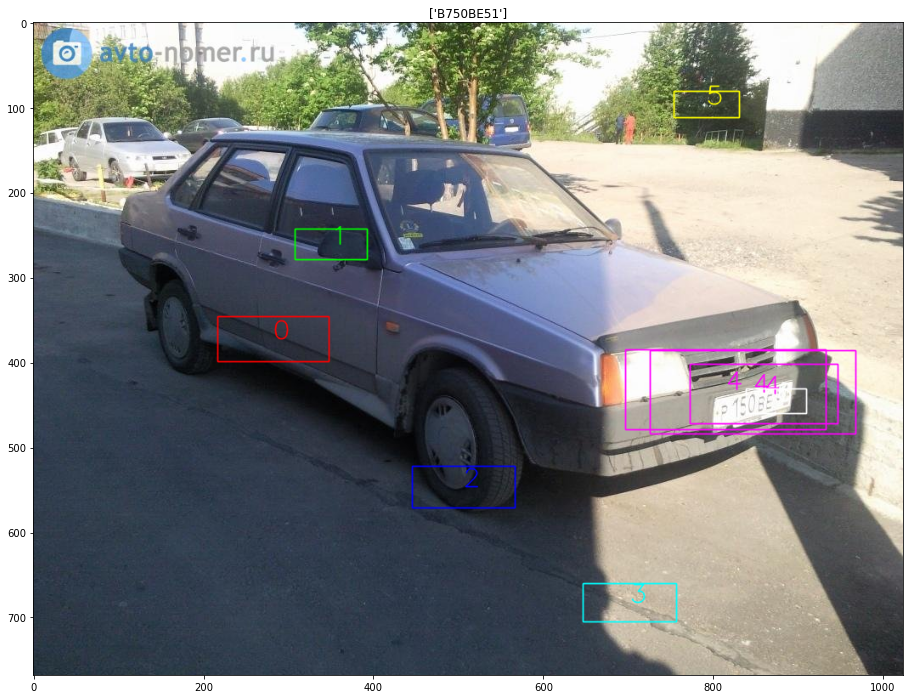

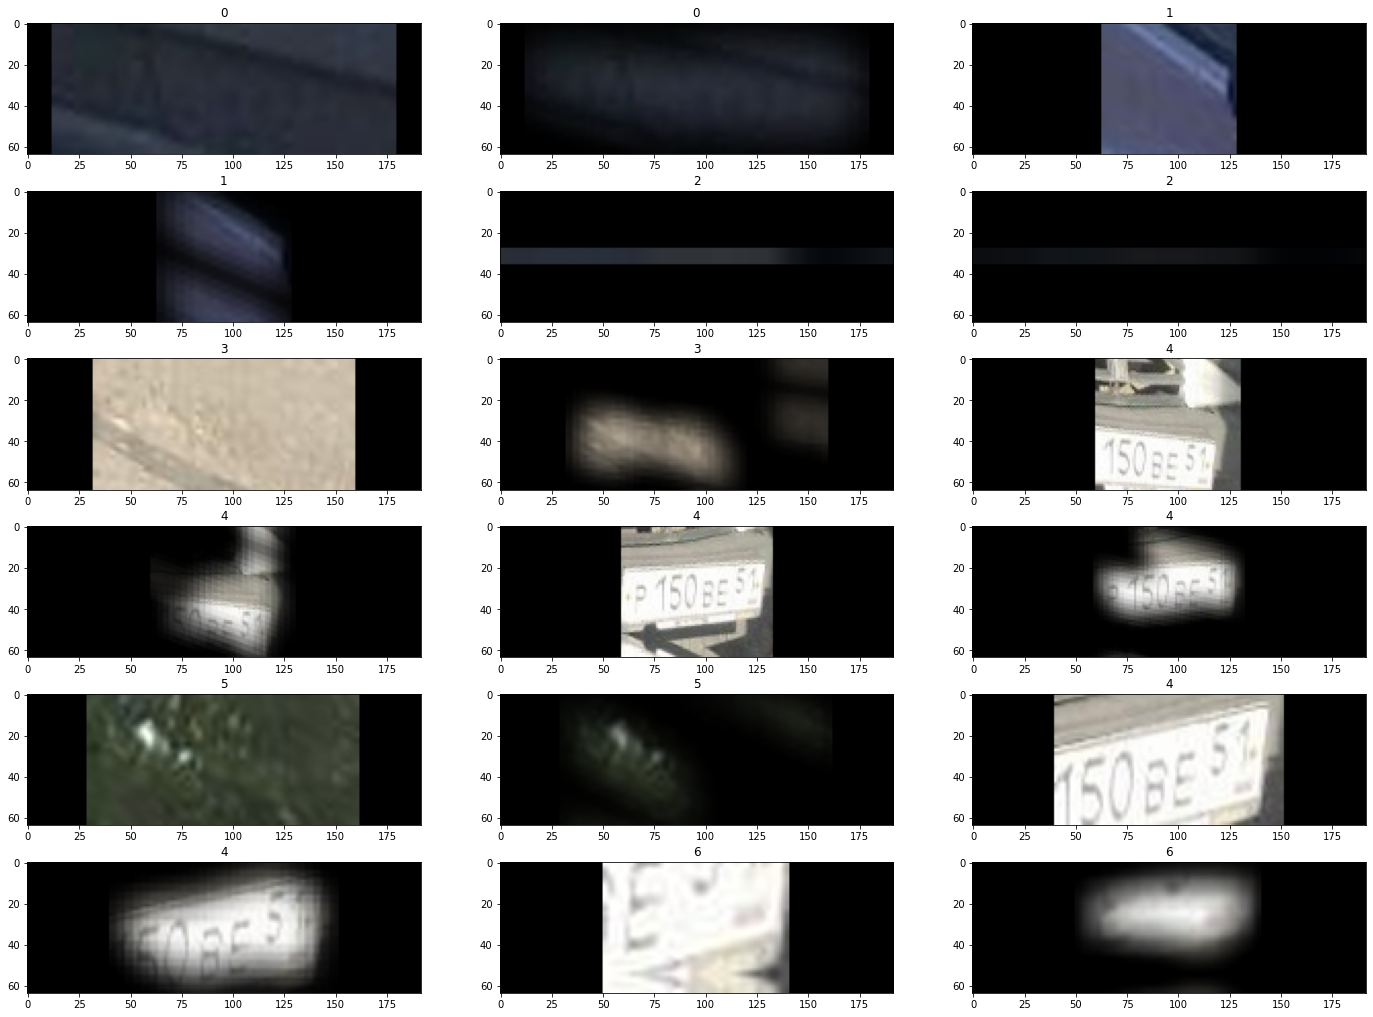

In [6]:
show(109)
show_crops(109)

In [7]:
for filename,pred in predictions.items():
    if len(pred)>3:
        print(filename, pred)

test/181.jpg ['O004OO197', 'O931OO199', 'M156MM197', 'A475AA197']
test/1835.jpg ['Y700YY77', 'A758AA77', 'A841MP77', 'K777EY177', 'O816OO77']
test/2060.jpeg ['C006KP197', 'M777MM99', 'E545KX99', 'A440AA35']


{0: {'A860MO67': 1.0, 'K803EO63': 1.0, 'P008MP77': 1.9, 'M002YY96': 1.9, 'M300HB27': 1.9, 'A300HB27': 1.9, 'M818MH27': 1.9, 'M308MB57': 1.9, 'A860MO27': 0.9, 'Y803EH123': 0.9, 'M827TH27': 1.0, 'Y826EO24': 1.0, 'P008MM72': 1.0, 'M008MY96': 1.0, 'M331HA27': 1.9, 'M308HA26': 1.9, 'M818HH27': 1.9, 'M818HK57': 1.9, 'K820TH27': 0.9, 'Y808HH123': 0.9, 'X008HH77': 0.9, 'X888MO92': 0.9}, 1: {'A852CO24': 1.0, 'A852TO21': 84.6, 'A852TO24': 4.6, 'B835XM194': 1.0, 'B825XB27': 1.9, 'A822CB124': 1.9, 'A822OB22': 1.9, 'A021KP127': 1.9, 'A822KT127': 1.9, 'A521YY27': 1.9, 'A524YY24': 1.9, 'B825CM124': 0.9, 'A852TO122': 1.0, 'B643XT27': 1.0, 'B623TB27': 1.0, 'A622CB124': 1.0, 'A858CB122': 1.0, 'A021KA197': 1.9, 'A802KO174': 1.9, 'A524YY127': 1.9, 'A884YY27': 1.9, 'C442XT27': 0.9, 'A423TO27': 0.9, 'A622CB122': 0.9, 'A522CO122': 0.9}, 2: {'P920XH62': 1.0, 'X905AB52': 1.0, 'P300PA76': 1.9, 'A300AA96': 1.9, 'A308HB27': 1.9, 'A000PB97': 1.9, 'A000MB97': 1.9, 'B700CB35': 1.9, 'P920XH66': 0.9, 'X955BB56': 0.9, 

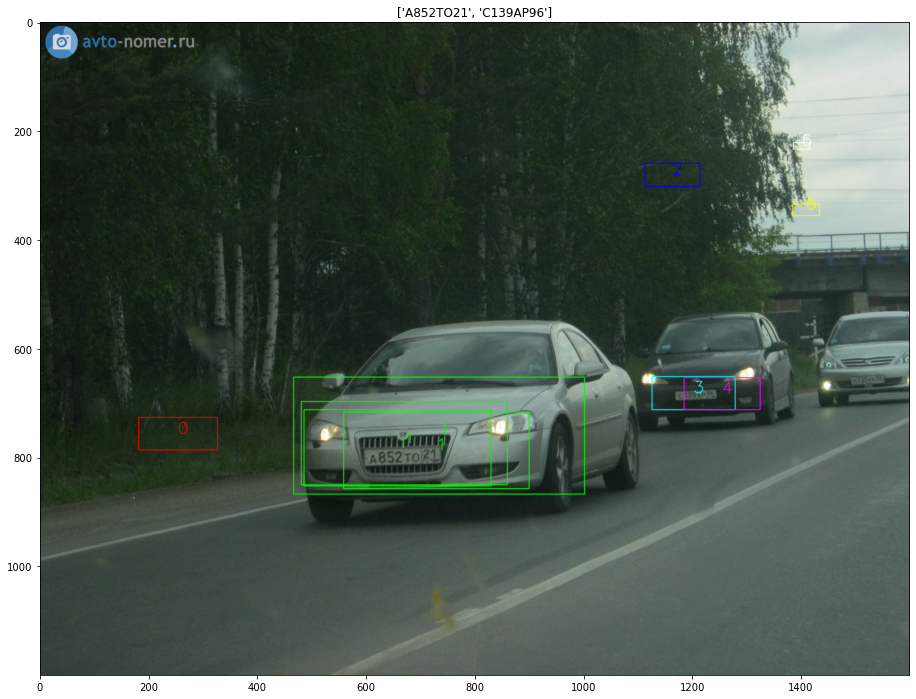

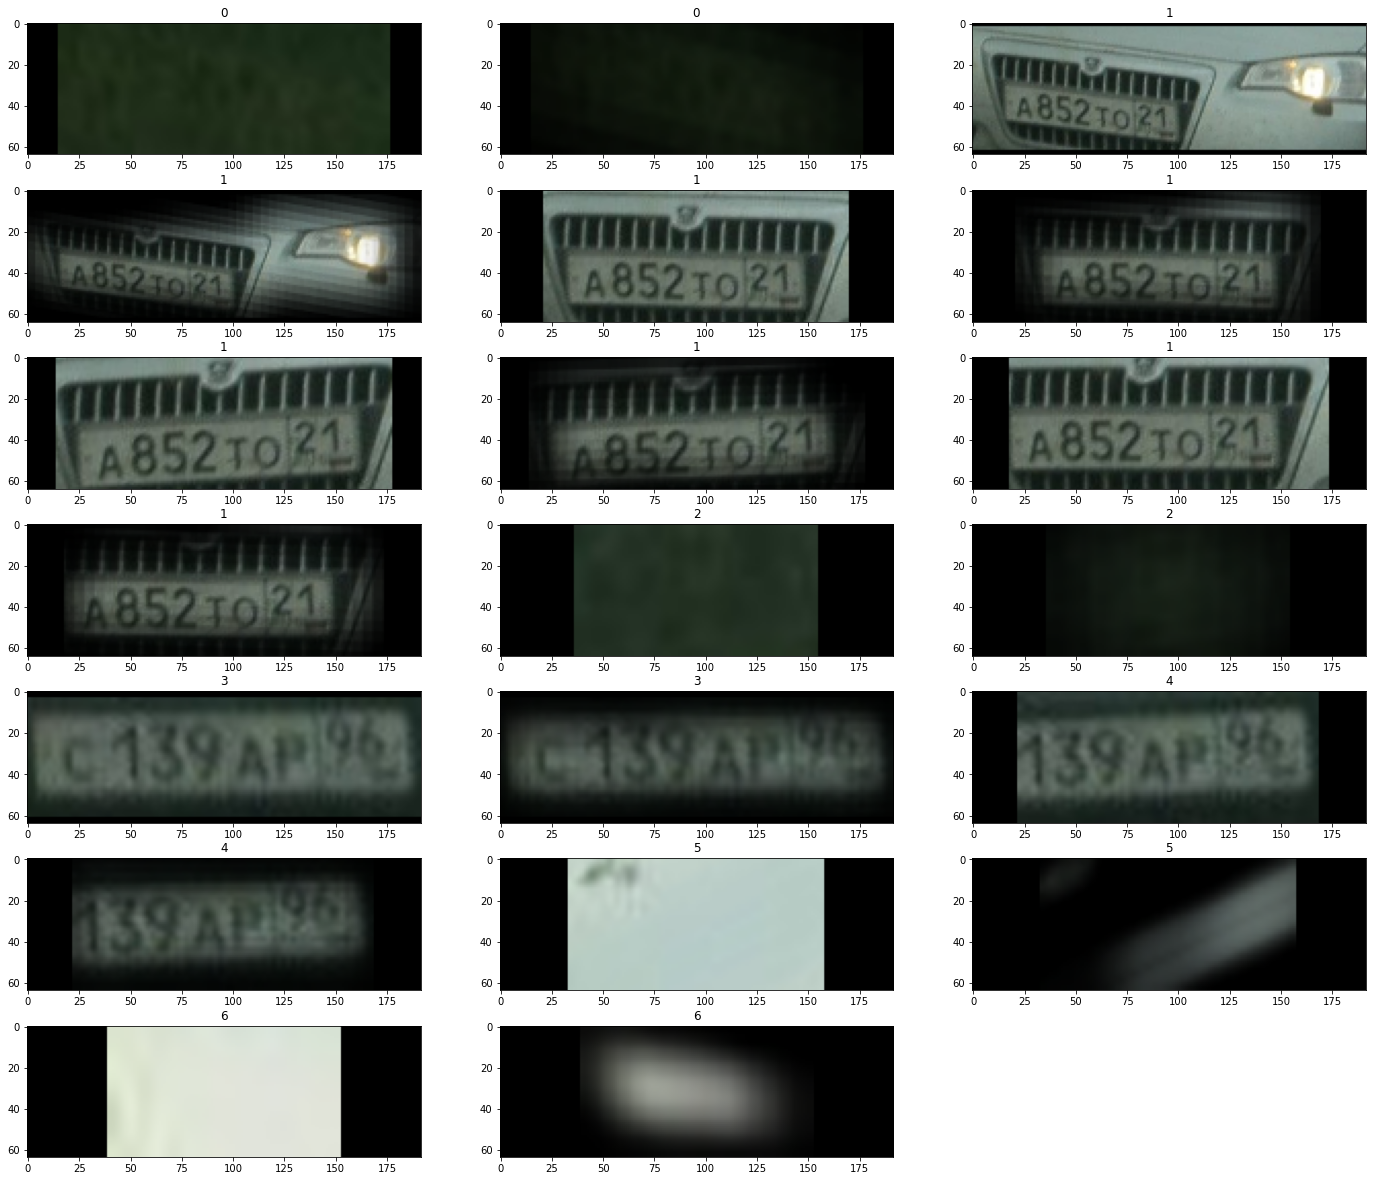

In [8]:
show(3)
show_crops(3)

{0: {'Y003KK190': 30.4}, 1: {'X248YH150': 4.8, 'K248YM150': 19.0, 'K248YH150': 1.9, 'X248YM150': 4.7}, 2: {'X248YM150': 60.8}, 3: {'A082MP97': 60.8}, 4: {'T236XM35': 1.0, 'M884EP24': 1.0, 'B326TA35': 1.9, 'B884AM35': 1.9, 'M000EE97': 1.9, 'B211AK35': 1.9, 'B244EE35': 1.9, 'B707CC35': 1.9, 'T736XM45': 0.9, 'M882CX64': 0.9, 'P981MM33': 1.0, 'O624YM75': 1.0, 'B388AA36': 1.0, 'B809OM35': 1.0, 'M702EA54': 1.9, 'B226AY35': 1.9, 'B717AK35': 1.9, 'B707TY35': 1.9, 'P981MM43': 0.9, 'O824CM26': 0.9, 'C336CX35': 0.9, 'C889OM35': 0.9}}


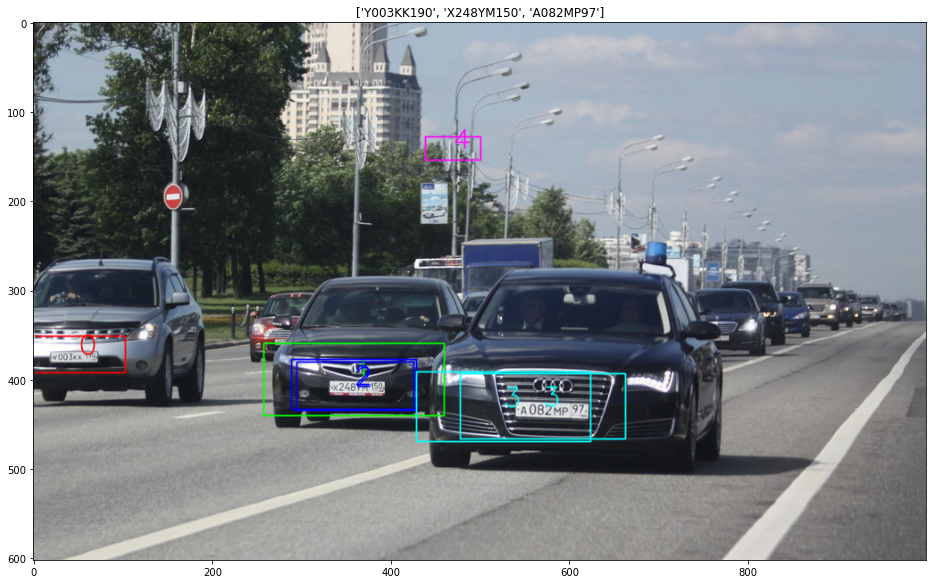

In [9]:
show(1732)

{0: {'C006KP197': 60.8}, 1: {'M777MM99': 60.8}, 2: {'A857AE35': 8.6, 'A857AA35': 13.2, 'A857AE32': 2.0, 'A857AK35': 1.9, 'A857AB35': 1.9, 'A857AP35': 2.8}, 3: {'E545KX99': 60.8}, 4: {'A440AA35': 44.7, 'A440AA32': 1.9, 'A440AC35': 1.9, 'A440AE35': 5.7, 'A440AA33': 2.8, 'A440AA34': 3.8}}


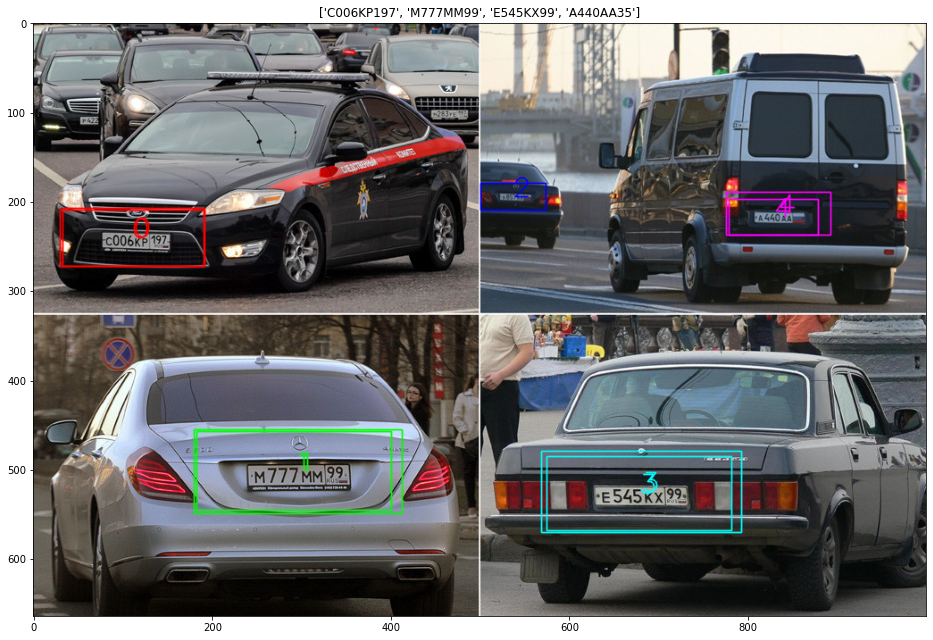

In [10]:
show(2060)

{0: {'O004OO197': 60.8}, 1: {'O931OO199': 60.8}, 2: {'B305KX35': 1.0, 'B810XM35': 1.0, 'A331XX35': 1.9, 'B354XX35': 1.9, 'B311TA35': 1.9, 'B335TT35': 1.9, 'B888XX35': 1.9, 'B845CX35': 1.9, 'B205TX35': 0.9, 'B815XM35': 0.9, 'B205EX35': 1.0, 'B810XK35': 1.0, 'M335PM14': 1.0, 'B055PX35': 1.0, 'B336CA35': 1.9, 'B316TY35': 1.9, 'B888XK35': 1.9, 'B365AX35': 1.9, 'B200TT35': 0.9, 'B216XX35': 0.9, 'A335OM35': 0.9}, 3: {'M156MM197': 60.8}, 4: {'A475AA197': 60.8}}


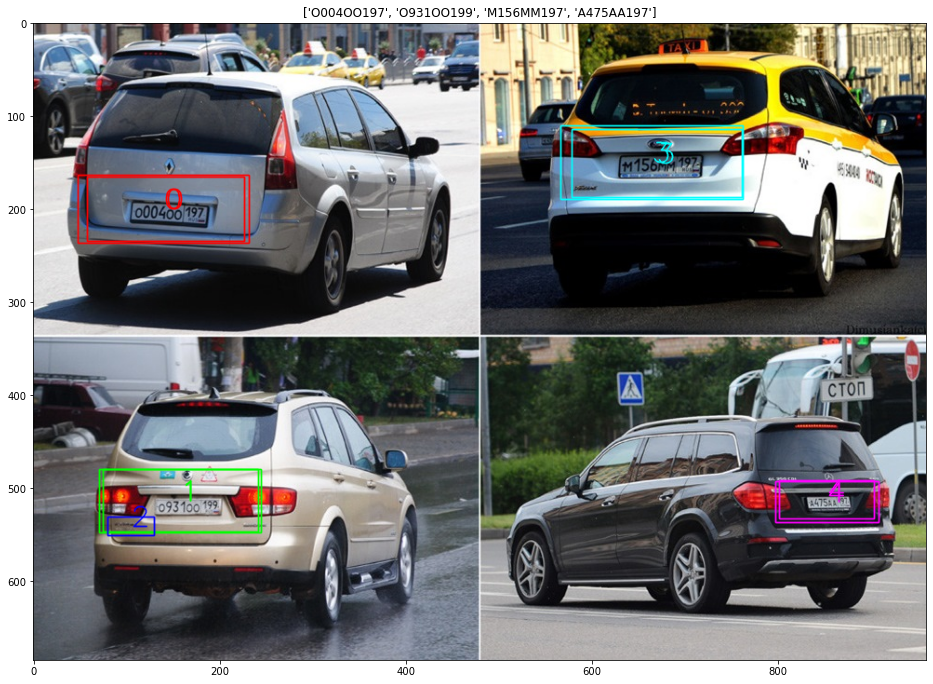

In [11]:
show(181)

{0: {'X700YY77': 3.8, 'Y700YY77': 26.6}, 1: {'A758AA77': 60.8}, 2: {'X000YY77': 5.7, 'H000YY77': 1.0, 'A700YY77': 2.9, 'A300YY77': 1.9, 'M700YY77': 1.9, 'T700YY77': 1.9, 'C700YYY7': 1.9, 'C200YYY7': 1.9, 'O000YY77': 1.9, 'M200YY77': 1.9, 'T000YY77': 1.9, 'C700YY7': 1.9, 'O700YY7': 1.9, 'X000YY74': 0.9, 'A400YY77': 0.9}, 3: {'A841MP77': 60.8}, 4: {'K777AY177': 4.7, 'K777EY177': 27.700000000000003, 'K777EY197': 1.9, 'K777EY192': 2.8, 'K777AY173': 3.8, 'K777EY173': 1.9, 'K777YY197': 1.9, 'K777YY17': 3.8, 'K777AY17': 1.9, 'K777EY1997': 1.9, 'K777BY177': 1.9, 'K777YY173': 1.0, 'C777YY177': 1.9, 'K777EY172': 2.8, 'K727EY173': 0.9}, 5: {'O816OO77': 57.0, 'O811OO77': 3.8}}


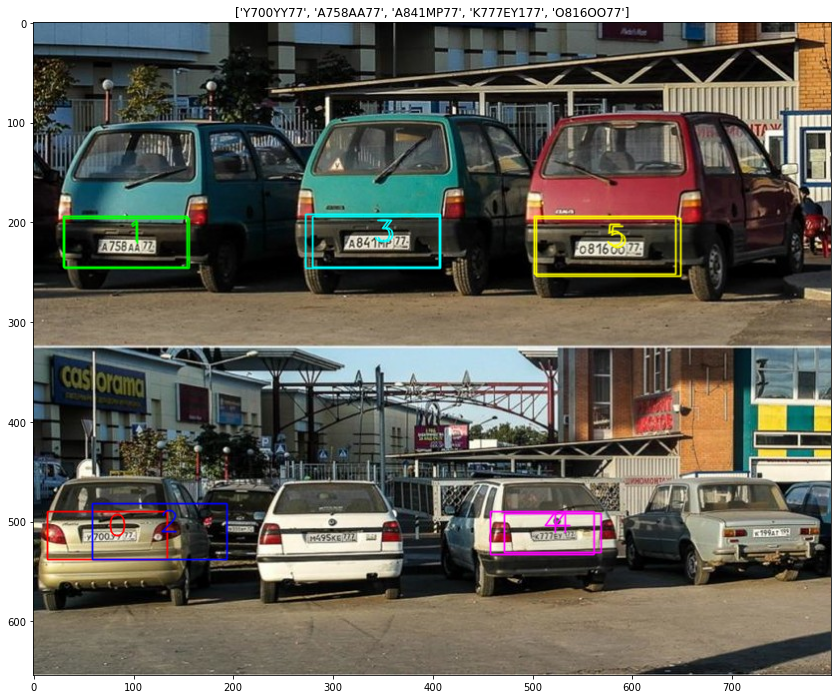

In [12]:
show(1835)

In [13]:
# Generate a submission file
submission_template=pd.read_csv(SUBMISSION_TEMPLATE)
with open('submission.csv', 'w') as wf:
    wf.write('file_name,plates_string\n')
    for file_name in submission_template.file_name.values:
        texts = predictions[file_name]
        wf.write('%s,%s\n' % (file_name,' '.join(texts)))

In [14]:
!head submission.csv

file_name,plates_string
test/0.jpg,O195KC96
test/1.jpg,O001OO24 O005OO24
test/2.jpg,H030MB33
test/3.jpg,A852TO21 C139AP96
test/4.bmp,B955ET35
test/5.bmp,B584XK35
test/6.jpg,B776YC77
test/7.bmp,T315TK35
test/8.jpg,P750BE54
